# E-tivity 1 (Weeks 1-2)

* Barry Clarke

* 24325082

## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv".

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small. Use an autoencoder to detect anomalies in the data. The correctness of the model can of course be checked.

### Task 4: VAE (completed by Sunday Week 2)

This task is a individual task and should **not** to be uploaded to the Group Locker. No direct support should be given via the forums. Marks will be deducted if the instructions are not followed (see rubrics). This part should be uploaded directly to Brightpsace.

Change the network to be a VAE. Again determine the optimal cutoff and plot the latent variables. Check how good the cutoffs were by constructing a confusion matrix or generating a classification report. Obviously for this task you need to use the Anom column.

**Hint** you can use the model topology from the AE (with the obvious modifications). I found that I had a good model (almost as good and the supervised learning model) when the KL divergence was small. You can print out both the KL divergence and reconstruction loss for each epoch. It can be tricky to train these type of models, so do not be surprised if you do not get a stellar result. What is more important is that you have the correct code to implement the VAE.

### Final Submission (complete by Sunday Week 2)

Submit Tasks 1-4 in a single notebook this before the deadline on Sunday.


--- Data Preprocessing ---
Training shape: (39277, 9)
Test shape: (9820, 9)

--- Starting VAE Training ---
Epoch 10: Loss=5.7247, Recon=4.3268, KL=1.3979
Epoch 20: Loss=5.3953, Recon=3.9721, KL=1.4233
Epoch 30: Loss=5.0114, Recon=3.5403, KL=1.4711
Epoch 40: Loss=4.8997, Recon=3.4260, KL=1.4737
Epoch 50: Loss=4.7993, Recon=3.3106, KL=1.4886
Epoch 60: Loss=4.6943, Recon=3.1992, KL=1.4951
Epoch 70: Loss=4.5877, Recon=3.0582, KL=1.5295
Epoch 80: Loss=4.3796, Recon=2.8161, KL=1.5635
Epoch 90: Loss=4.1561, Recon=2.5754, KL=1.5807
Epoch 100: Loss=4.0436, Recon=2.4541, KL=1.5896
Epoch 110: Loss=4.0068, Recon=2.4136, KL=1.5932
Epoch 120: Loss=3.9541, Recon=2.3564, KL=1.5976
Epoch 130: Loss=3.9206, Recon=2.3234, KL=1.5972
Epoch 140: Loss=3.9038, Recon=2.2954, KL=1.6084
Epoch 150: Loss=3.8872, Recon=2.2794, KL=1.6077
Training complete.


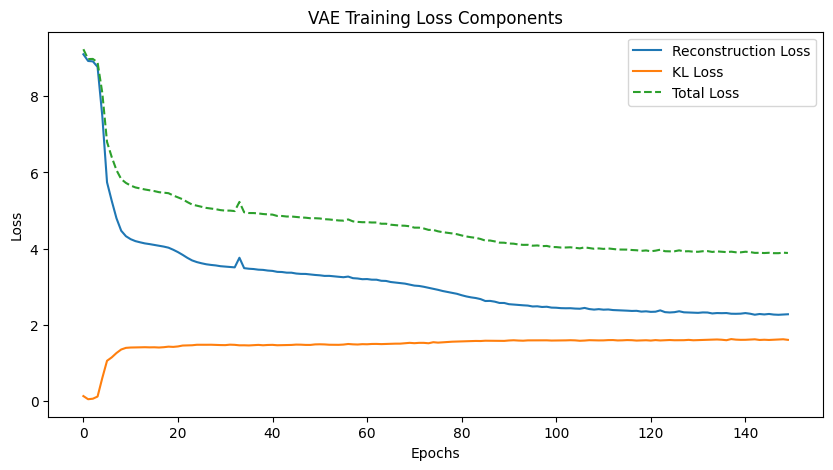

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Calculated Threshold (92nd percentile): 0.3395


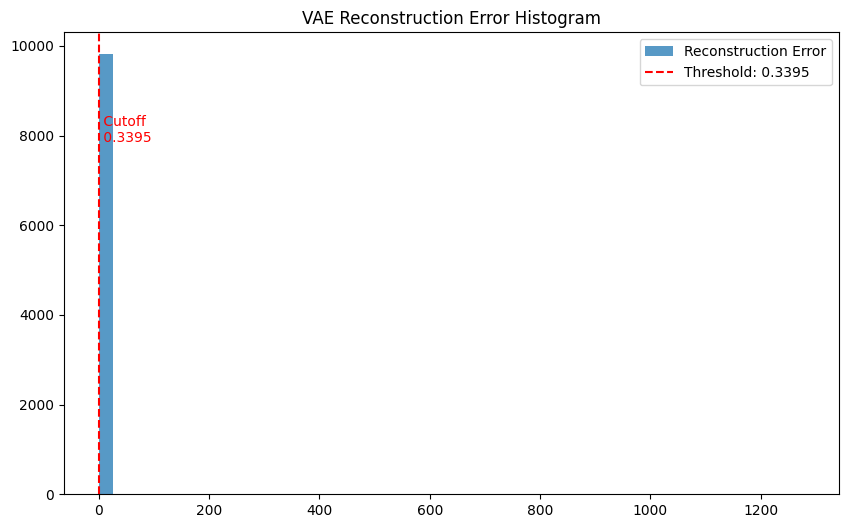


VAE Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      9100
           1       0.12      0.14      0.13       720

    accuracy                           0.87      9820
   macro avg       0.53      0.53      0.53      9820
weighted avg       0.87      0.87      0.87      9820

Confusion Matrix:


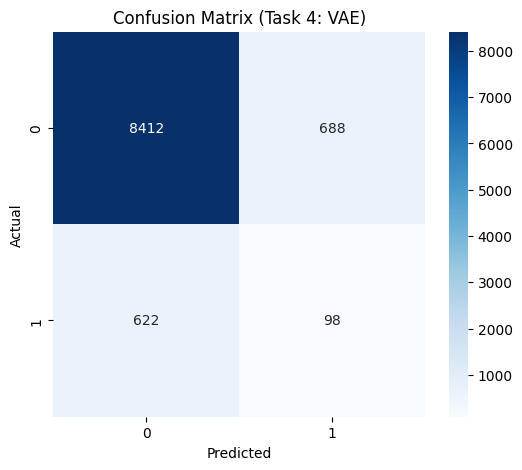

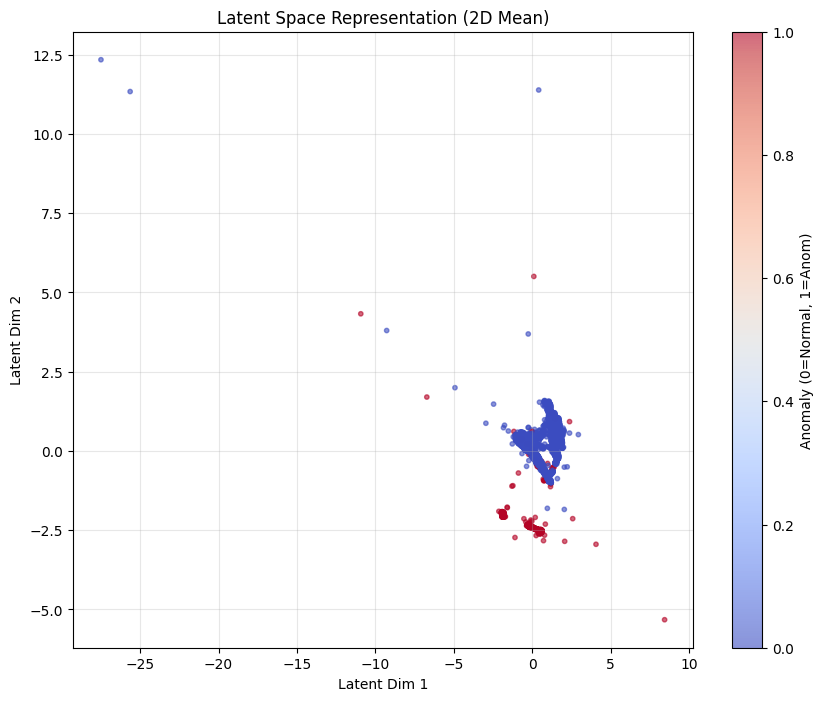

In [6]:
# ==========================================
# Task 4: Variational Autoencoder (VAE)
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ---------------------------------------------------------
# 1. Data Preprocessing
# ---------------------------------------------------------
print("--- Data Preprocessing ---")
# Load Data
df = pd.read_csv('data.csv')

# Separate features and target
X = df.drop('Anom', axis=1)
y = df['Anom']

# Split Data (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training shape: {X_train_scaled.shape}")
print(f"Test shape: {X_test_scaled.shape}")

# ---------------------------------------------------------
# 2. VAE Model Definition
# ---------------------------------------------------------
class DenseVAE(tf.keras.Model):
    def __init__(self, input_dim, latent_dim=2):
        super(DenseVAE, self).__init__()
        self.latent_dim = latent_dim

        # --- Encoder ---
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(input_dim,)),
            Dense(7, activation='relu'),
            Dense(4, activation='relu'),
            Dense(latent_dim + latent_dim) # Output: mean and logvar
        ])

        # --- Decoder ---
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            Dense(4, activation='relu'),
            Dense(7, activation='relu'),
            Dense(input_dim, activation='linear')
        ])

        # Trackers for metrics
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z):
        return self.decoder(z)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # 1. Forward pass
            mean, logvar = self.encode(data)
            z = self.reparameterize(mean, logvar)
            reconstruction = self.decode(z)

            # 2. Calculate Losses
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=1)
            )
            kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        # 3. Backpropagation
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        # 4. Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# ---------------------------------------------------------
# 3. Model Training
# ---------------------------------------------------------
# Define a callback to print progress every 10 epochs
class PrintProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}: Loss={logs['loss']:.4f}, Recon={logs['reconstruction_loss']:.4f}, KL={logs['kl_loss']:.4f}")

input_dim = X_train_scaled.shape[1]
vae = DenseVAE(input_dim, latent_dim=2)
vae.compile(optimizer=Adam(learning_rate=0.0005))

print("\n--- Starting VAE Training ---")
history = vae.fit(
    X_train_scaled,
    epochs=150,
    batch_size=32,
    shuffle=True,
    verbose=0,
    callbacks=[PrintProgress()]
)
print("Training complete.")

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(history.history['kl_loss'], label='KL Loss')
plt.plot(history.history['loss'], label='Total Loss', linestyle='--')
plt.title('VAE Training Loss Components')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ---------------------------------------------------------
# 4. Anomaly Detection
# ---------------------------------------------------------
# Predict on test set
reconstructions = vae.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# Determine Cutoff (92nd percentile)
threshold = np.percentile(mse, 92)
print(f"\nCalculated Threshold (92nd percentile): {threshold:.4f}")

# Histogram
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(mse, bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.text(threshold, max(counts)*0.8, f' Cutoff\n {threshold:.4f}', color='red')
plt.title('VAE Reconstruction Error Histogram')
plt.legend()
plt.show()

# ---------------------------------------------------------
# 5. Evaluation
# ---------------------------------------------------------
y_pred = [1 if e > threshold else 0 for e in mse]

print("\nVAE Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Task 4: VAE)')
plt.show()

# ---------------------------------------------------------
# 6. Latent Space Visualisation
# ---------------------------------------------------------
z_mean, z_log_var = vae.encode(X_test_scaled)
z_mean = z_mean.numpy()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='coolwarm', alpha=0.6, s=10)
plt.colorbar(scatter, label='Anomaly (0=Normal, 1=Anom)')
plt.title('Latent Space Representation (2D Mean)')
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.grid(True, alpha=0.3)
plt.show()

## Reflection

There are no specific marks allocated for a reflection. However due consideration will be given if pertinent comments or valuable insights are made.

BASELINE (Rubbish)

VAE Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      9100
           1       0.12      0.14      0.13       720

    accuracy                           0.87      9820
   macro avg       0.53      0.53      0.53      9820
weighted avg       0.87      0.87      0.87      9820



SECOND MODEL

VAE Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9100
           1       0.50      0.55      0.53       720

    accuracy                           0.93      9820
   macro avg       0.73      0.75      0.74      9820
weighted avg       0.93      0.93      0.93      9820




--- Data Preprocessing ---
Training shape: (39277, 9)
Test shape: (9820, 9)

--- Starting VAE Training ---
Epoch 10: Loss=13.7794, Val_Loss=14.6096
Epoch 20: Loss=5.1860, Val_Loss=13.4219
Epoch 30: Loss=3.2956, Val_Loss=13.5393
Epoch 40: Loss=2.9740, Val_Loss=13.4178
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 28.
Training complete. Stopped at epoch 43


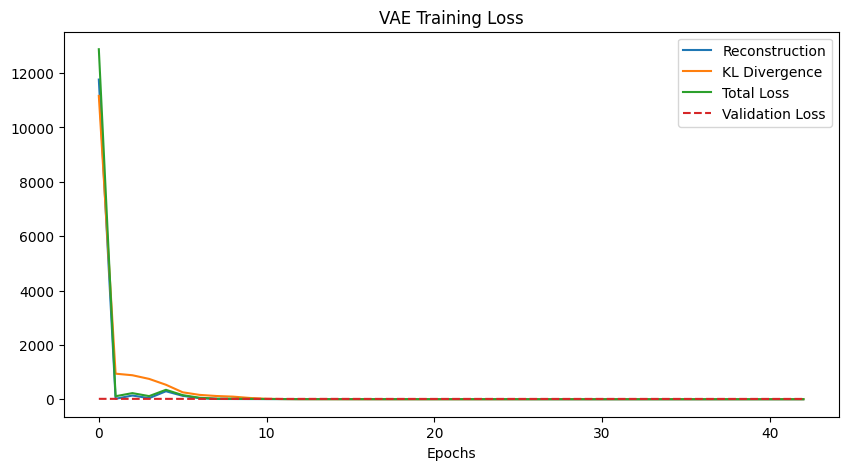

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Calculated Threshold (92nd percentile): 0.1197


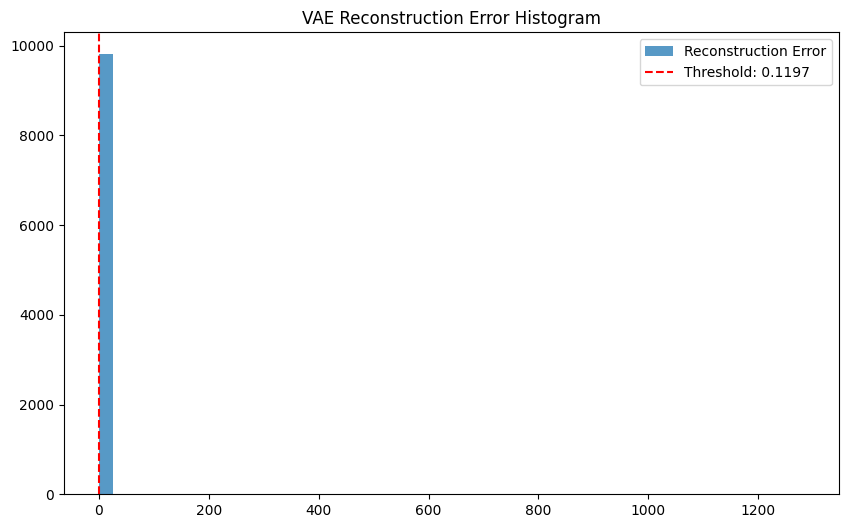


VAE Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9100
           1       0.50      0.55      0.53       720

    accuracy                           0.93      9820
   macro avg       0.73      0.75      0.74      9820
weighted avg       0.93      0.93      0.93      9820

Confusion Matrix:


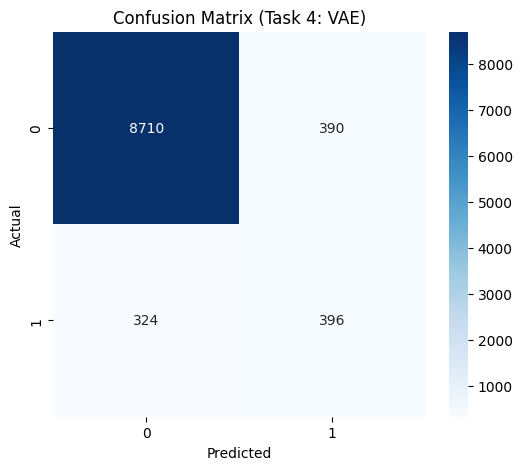

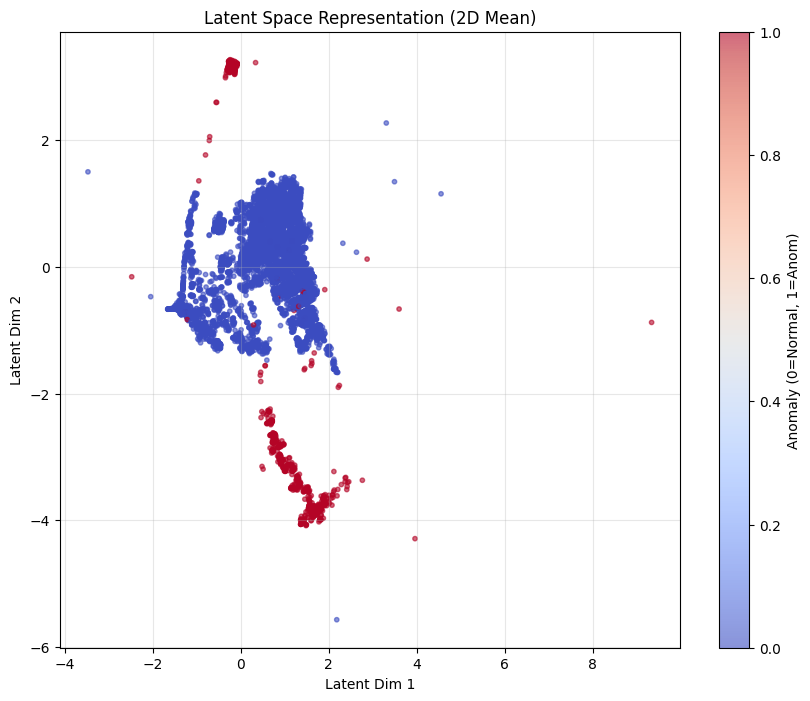

In [7]:
# CHANGES
# ==========================================
# Task 4: Variational Autoencoder (VAE) - Optimised
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------------------------------------
# 1. Data Preprocessing
# ---------------------------------------------------------
print("--- Data Preprocessing ---")
df = pd.read_csv('data.csv')

X = df.drop('Anom', axis=1)
y = df['Anom']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training shape: {X_train_scaled.shape}")
print(f"Test shape: {X_test_scaled.shape}")

# ---------------------------------------------------------
# 2. VAE Model Definition (Optimised)
# ---------------------------------------------------------
class DenseVAE(tf.keras.Model):
    def __init__(self, input_dim, latent_dim=2, kl_weight=0.1):
        super(DenseVAE, self).__init__()
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight  # Weight to scale down KL Divergence

        # --- Encoder ---
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(input_dim,)),
            Dense(7, activation='relu'),
            Dense(4, activation='relu'),
            Dense(latent_dim + latent_dim) # Output: mean and logvar
        ])

        # --- Decoder ---
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            Dense(4, activation='relu'),
            Dense(7, activation='relu'),
            Dense(input_dim, activation='linear')
        ])

        # Trackers
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z):
        return self.decoder(z)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z)

    # Training Step
    def train_step(self, data):
        if isinstance(data, tuple): data = data[0]

        with tf.GradientTape() as tape:
            mean, logvar = self.encode(data)
            z = self.reparameterize(mean, logvar)
            reconstruction = self.decode(z)

            # Reconstruction Loss
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))

            # KL Divergence
            kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Total Loss (Weighted)
            total_loss = reconstruction_loss + (self.kl_weight * kl_loss)

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {"loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result()}

    # Validation Step (Critical for Early Stopping)
    def test_step(self, data):
        if isinstance(data, tuple): data = data[0]

        mean, logvar = self.encode(data)
        z = self.reparameterize(mean, logvar)
        reconstruction = self.decode(z)

        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
        kl_loss = -0.5 * (1 + logvar - tf.square(mean) - tf.exp(logvar))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + (self.kl_weight * kl_loss)

        return {"loss": total_loss,
                "reconstruction_loss": reconstruction_loss,
                "kl_loss": kl_loss}

# ---------------------------------------------------------
# 3. Model Training
# ---------------------------------------------------------
# Custom Callback
class PrintProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}: Loss={logs['loss']:.4f}, Val_Loss={logs['val_loss']:.4f}")

# Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

input_dim = X_train_scaled.shape[1]
# We reduce kl_weight to 0.1 to prioritise better reconstruction (better anomaly detection)
vae = DenseVAE(input_dim, latent_dim=2, kl_weight=0.1)
vae.compile(optimizer=Adam(learning_rate=0.0005))

print("\n--- Starting VAE Training ---")
start_time = time.time()

history = vae.fit(
    X_train_scaled,
    epochs=1000, # Increased max epochs, relying on EarlyStopping
    batch_size=32,
    shuffle=True,
    validation_data=(X_test_scaled, X_test_scaled), # Required for val_loss
    verbose=0,
    callbacks=[PrintProgress(), early_stop]
)

print(f"Training complete. Stopped at epoch {len(history.history['loss'])}")

# Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(history.history['reconstruction_loss'], label='Reconstruction')
plt.plot(history.history['kl_loss'], label='KL Divergence')
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('VAE Training Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# ---------------------------------------------------------
# 4. Anomaly Detection
# ---------------------------------------------------------
reconstructions = vae.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# Threshold at 92nd percentile
threshold = np.percentile(mse, 92)
print(f"\nCalculated Threshold (92nd percentile): {threshold:.4f}")

# Histogram
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(mse, bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title('VAE Reconstruction Error Histogram')
plt.legend()
plt.show()

# ---------------------------------------------------------
# 5. Evaluation
# ---------------------------------------------------------
y_pred = [1 if e > threshold else 0 for e in mse]

print("\nVAE Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Task 4: VAE)')
plt.show()

# ---------------------------------------------------------
# 6. Latent Space Visualization
# ---------------------------------------------------------
z_mean, z_log_var = vae.encode(X_test_scaled)
z_mean = z_mean.numpy()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='coolwarm', alpha=0.6, s=10)
plt.colorbar(scatter, label='Anomaly (0=Normal, 1=Anom)')
plt.title('Latent Space Representation (2D Mean)')
plt.xlabel('Latent Dim 1')
plt.ylabel('Latent Dim 2')
plt.grid(True, alpha=0.3)
plt.show()